<code>calculate_S2S_model_bias_vs_month_mean_SD.ipynb</code>.  This notebook calculates bias (model - obs) in sea ice extent mean and standard deviation for each S2S model as a function of forecast month and region. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_model_climatology
from S2S_sea_ice_preprocess import create_obs_climatology 

## Overview

<li>1) Load model netCDF files, combine with CTRL, and use common reforecast period. <br>
if NCEP, use entire period </li>
<li> 2) Add aggregate regions </li>
<li> 3) Create climatology--model: calculate date of year for valid date, lead time in weeks.<br>
<li> 4) Create observed climatology (static, using only common reforecast period) </li>
<li> 5) Calculate bias at desired lead period (0 - <code>max_lead</code>) for each region, in each model, as a function of forecast month  
    $$SIE_{bias} = \overline{SIE_{model}(m,date)} - SIE_{obs}(m,date),$$
    where the overline indicates averaging from lead days 0 - <code>max_lead</code>

In [2]:
model_names_ALL = ['ecmwf','ncep','ukmo','metreofr']
obs_name = 'NSIDC_0079'
COMMON_RF = True # we want to compare the reforecasts to obs over the same 15 year period
MAX_LEAD = 1 #max lead in days

Here we want to look at all the models at once.  So we'll load each model, calculate the aggregate regions, get the ensemble mean, and create the climatology before combining everything into one dataframe.

In [3]:
SIE_df_ALL = pd.DataFrame()
SIE_df_weekly_ALL = pd.DataFrame()
for model_name in model_names_ALL:
    print('loading ',model_name)
    # Load
    SIE = load_model(model_name)
    print('loaded ',model_name)
    # Create aggregate regions
    SIE = create_aggregate_regions(SIE)
    print('combined regions')
    # Take ensemble mean and get lead time in days
    SIE_ens_mean = SIE.mean(dim='ensemble')
    regions = SIE.region_names
    lead_days = SIE.fore_time.dt.days
    # Convert to dataframe, rename some columns, and get the date of the forecast by adding the fore_time to init_date
    SIE_df = SIE_ens_mean.to_dataframe().reset_index()
    SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
    SIE_df = SIE_df.rename(columns={'region_names':'region',
                               'fore_time':'lead time (days)',
                               'init_time':'init date',
                               'Extent':'SIE'})
    SIE_df = create_model_climatology(SIE_df,7)
    SIE_df['model name'] = model_name
    
# Create climatology
    SIE_df_ALL = SIE_df_ALL.append(SIE_df)
    #SIE_df_weekly_ALL = SIE_df_weekly_ALL.append(SIE_df_weekly)

loading  ecmwf
<xarray.Dataset>
Dimensions:       (ensemble: 10, fore_time: 46, init_time: 2080, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 44 days 45 days
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 9
  * init_time     (init_time) datetime64[ns] 1998-08-06 ... 2018-08-01
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(10, 1, 46, 15), meta=np.ndarray>
loaded  ecmwf
combined regions
loading  ncep
<xarray.Dataset>
Dimensions:       (ensemble: 3, fore_time: 43, init_time: 4523, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 42 days

Load obs

In [4]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [5]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})

Calculate our observed climatology using either the full period or the common reforecast period only

In [6]:
if COMMON_RF == True:
    obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1999,2015))]
    obs_SIE = create_obs_climatology(obs_SIE)
    time_str = 'COMMON_RF'
    print('common reforecast')
else:
    time_str = 'FULL_PERIOD'
    obs_SIE = create_obs_climatology(obs_SIE)
    print('full period')
print('observed climatology created')

common reforecast
observed climatology created


In [7]:
obs_SIE['model name'] = obs_name

In [8]:
SIE_df_ALL['valid date month'] = pd.to_datetime(SIE_df_ALL['valid date']).dt.month
obs_SIE['valid date month'] = pd.to_datetime(obs_SIE['valid date']).dt.month
SIE_df_ALL

,init date,lead time (days),nregions,region,SIE,valid date,valid date of yr,SIE clim,SIE anom,model name,valid date month
0,1999-01-03,0 days,99,panArctic,12.877095,1999-01-03,01-03,12.305199,0.571896,ecmwf,1
1,1999-01-03,0 days,2,Sea of Okhotsk,0.582058,1999-01-03,01-03,0.442489,0.139569,ecmwf,1
2,1999-01-03,0 days,3,Bering,0.460486,1999-01-03,01-03,0.477781,-0.017295,ecmwf,1
3,1999-01-03,0 days,4,Hudson Bay,1.081344,1999-01-03,01-03,1.075383,0.005961,ecmwf,1
4,1999-01-03,0 days,5,St John,0.059987,1999-01-03,01-03,0.024223,0.035764,ecmwf,1
...,...,...,...,...,...,...,...,...,...,...,...
921595,2014-12-22,59 days,20,Kara-Laptev Sea,1.528190,2015-02-19,02-19,1.629595,-0.101405,metreofr,2
921596,2014-12-22,59 days,21,Barents-Kara-Laptev Sea,2.143262,2015-02-19,02-19,2.254153,-0.110891,metreofr,2
921597,2014-12-22,59 days,22,East Siberian-Beaufort-Chukchi Sea,2.768463,2015-02-19,02-19,2.953695,-0.185232,metreofr,2
921598,2014-12-22,59 days,23,Atlantic,1.719759,2015-02-19,02-19,1.913507,-0.193748,metreofr,2


Group by model name, region, lead time (for model output only), and the forecast valid date, and subtract the observed SIE from the model prediction of SIE

In [9]:
SIE_model_gb = SIE_df_ALL.groupby(['region','valid date month','model name','lead time (days)'])['SIE','SIE clim','SIE anom'].mean()
SIE_obs_gb = obs_SIE.groupby(['region','valid date month'])['SIE','SIE clim','SIE anom'].mean()
SIE_err = SIE_model_gb[['SIE','SIE clim','SIE anom']] - SIE_obs_gb[['SIE','SIE clim','SIE anom']]
SIE_err_pct = SIE_err[['SIE','SIE clim','SIE anom']].divide(SIE_obs_gb[['SIE','SIE clim','SIE anom']])

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Group by model name, region, lead time (for model output only), and the forecast valid date, and subtract the observed SIE std from the model SIE std

In [10]:
SIE_model_gb_sd = SIE_df_ALL.groupby(['region','valid date month','model name','lead time (days)'])['SIE','SIE clim','SIE anom'].std()
SIE_obs_gb_sd = obs_SIE.groupby(['region','valid date month'])['SIE','SIE clim','SIE anom'].std()
SIE_err_sd = SIE_model_gb_sd[['SIE','SIE clim','SIE anom']] - SIE_obs_gb_sd[['SIE','SIE clim','SIE anom']]
SIE_err_pct_sd = SIE_err_sd[['SIE','SIE clim','SIE anom']].divide(SIE_obs_gb_sd[['SIE','SIE clim','SIE anom']])

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [11]:
SIE_err[['SIE sd','SIE clim sd','SIE anom sd']] = SIE_err_sd[['SIE','SIE clim','SIE anom']]
SIE_err

SIE  SIE clim  \
region    valid date month lead time (days) model name                       
Atlantic  1                0 days           ecmwf      -0.193609 -0.193609   
                           1 days           ecmwf      -0.203903 -0.203903   
                           2 days           ecmwf      -0.190934 -0.190934   
                           3 days           ecmwf      -0.177339 -0.177339   
                           4 days           ecmwf      -0.177914 -0.177914   
...                                                          ...       ...   
panArctic 12               55 days          ukmo        0.006779  0.006779   
                           56 days          ukmo        0.076440  0.076440   
                           57 days          ukmo        0.145000  0.145000   
                           58 days          ukmo        0.211060  0.211060   
                           59 days          ukmo        0.277028  0.277028   

                                                            SIE anom  \
region    valid date month lead time (days) model name                 
Atlantic  1                0 days           ecmwf       1.008254e-16   
                           1 days           ecmwf      -3.178461e-17   
                           2 days           ecmwf      -5.183030e-17   
                           3 days           ecmwf      -9.037971e-17   
                           4 days           ecmwf      -6.300963e-17   
...                                                              ...   
panArctic 12               55 days          ukmo       -1.539987e-16   
                           56 days          ukmo       -4.870656e-16   
                           57 days          ukmo       -6.813546e-16   
                           58 days          ukmo       -7.646213e-16   
                           59 days          ukmo       -9.589104e-16   

                                                          SIE sd  SIE clim sd  \
region    valid date month lead time (days) model name                          
Atlantic  1                0 days           ecmwf      -0.019181    -0.015065   
                           1 days           ecmwf      -0.020251    -0.013989   
                           2 days           ecmwf      -0.020143    -0.015695   
                           3 days           ecmwf      -0.019751    -0.016877   
                           4 days           ecmwf      -0.024456    -0.022638   
...                                                          ...          ...   
panArctic 12               55 days          ukmo        0.138007     0.117414   
                           56 days          ukmo        0.122882     0.101953   
                           57 days          ukmo        0.101535     0.080428   
                           58 days          ukmo        0.082331     0.060931   
                           59 days          ukmo        0.064502     0.043528   

                                                        SIE anom sd  
region    valid date month lead time (days) model name               
Atlantic  1                0 days           ecmwf         -0.013352  
                           1 days           ecmwf         -0.015207  
                           2 days           ecmwf         -0.014100  
                           3 days           ecmwf         -0.012991  
                           4 days           ecmwf         -0.015256  
...                                                             ...  
panArctic 12               55 days          ukmo           0.072998  
                           56 days          ukmo           0.069706  
                           57 days          ukmo           0.064433  
                           58 days          ukmo           0.059835  
                           59 days          ukmo           0.054290  

[50160 rows x 6 columns]

In [12]:
SIE_err_pct = SIE_err_pct*100
SIE_err[['SIE pct','SIE clim pct','SIE anom pct']] = SIE_err_pct

In [13]:
SIE_err_rs = SIE_err.reset_index()
#SIE_err_rs['valid month'] = pd.to_datetime(SIE_err_rs['valid date']).dt.month

In [14]:
fname_save = '../DATA/RAW_ERRORS_all_S2S_models_OBS_{obs_name}_{time_str}.csv'.format(obs_name=obs_name,time_str=time_str)
#SIE_err_rs.to_csv(fname_save)

In [15]:
#SIE_err_trim = SIE_err.xs('Kara-Laptev Sea').reset_index()
min_lead = 14
max_lead = 28
SIE_err_trim = SIE_err_rs[SIE_err_rs['lead time (days)'].isin(pd.Timedelta(days=i) for i in range(min_lead,max_lead+1))]
seas_sel_ALL = [[],[6,7,8],[10,11,12],[1,2,3],[10,11,12,1,2,3],[4,5,6,7,8,9]]
seas_str_ALL = ['ALL','JJA','SON','JFM','SONDJF','MAMJJA'] 
#pd.Timedelta(7,'D')
SIE_seas_err_mean = pd.DataFrame()
for iseas in np.arange(0,len(seas_sel_ALL)):
    if not seas_sel_ALL[iseas]:
        i_SIE_err = SIE_err_trim
    else:
        i_SIE_err = SIE_err_trim[SIE_err_trim['valid date month'].isin(seas_sel_ALL[iseas])]
    # add string for season and group
    i_SIE_err_means = i_SIE_err.groupby(['region','model name']).mean()
    i_SIE_err_means['Season'] = seas_str_ALL[iseas]
    #
    SIE_seas_err_mean = SIE_seas_err_mean.append(i_SIE_err_means)
#SIE_err_groups = SIE_err_trim.groupby(['region','model name','valid date month'])['SIE','SIE clim',
#                                                         'SIE anom','SIE sd','SIE clim sd','SIE anom sd'].mean()
regions_sel = ['panArctic','Central Arctic','East Siberian-Beaufort-Chukchi Sea',
              'Kara-Laptev Sea','Barents Sea','East Greenland Sea']
SIE_seas_err_plt = SIE_seas_err_mean.reset_index().set_index(['region'])

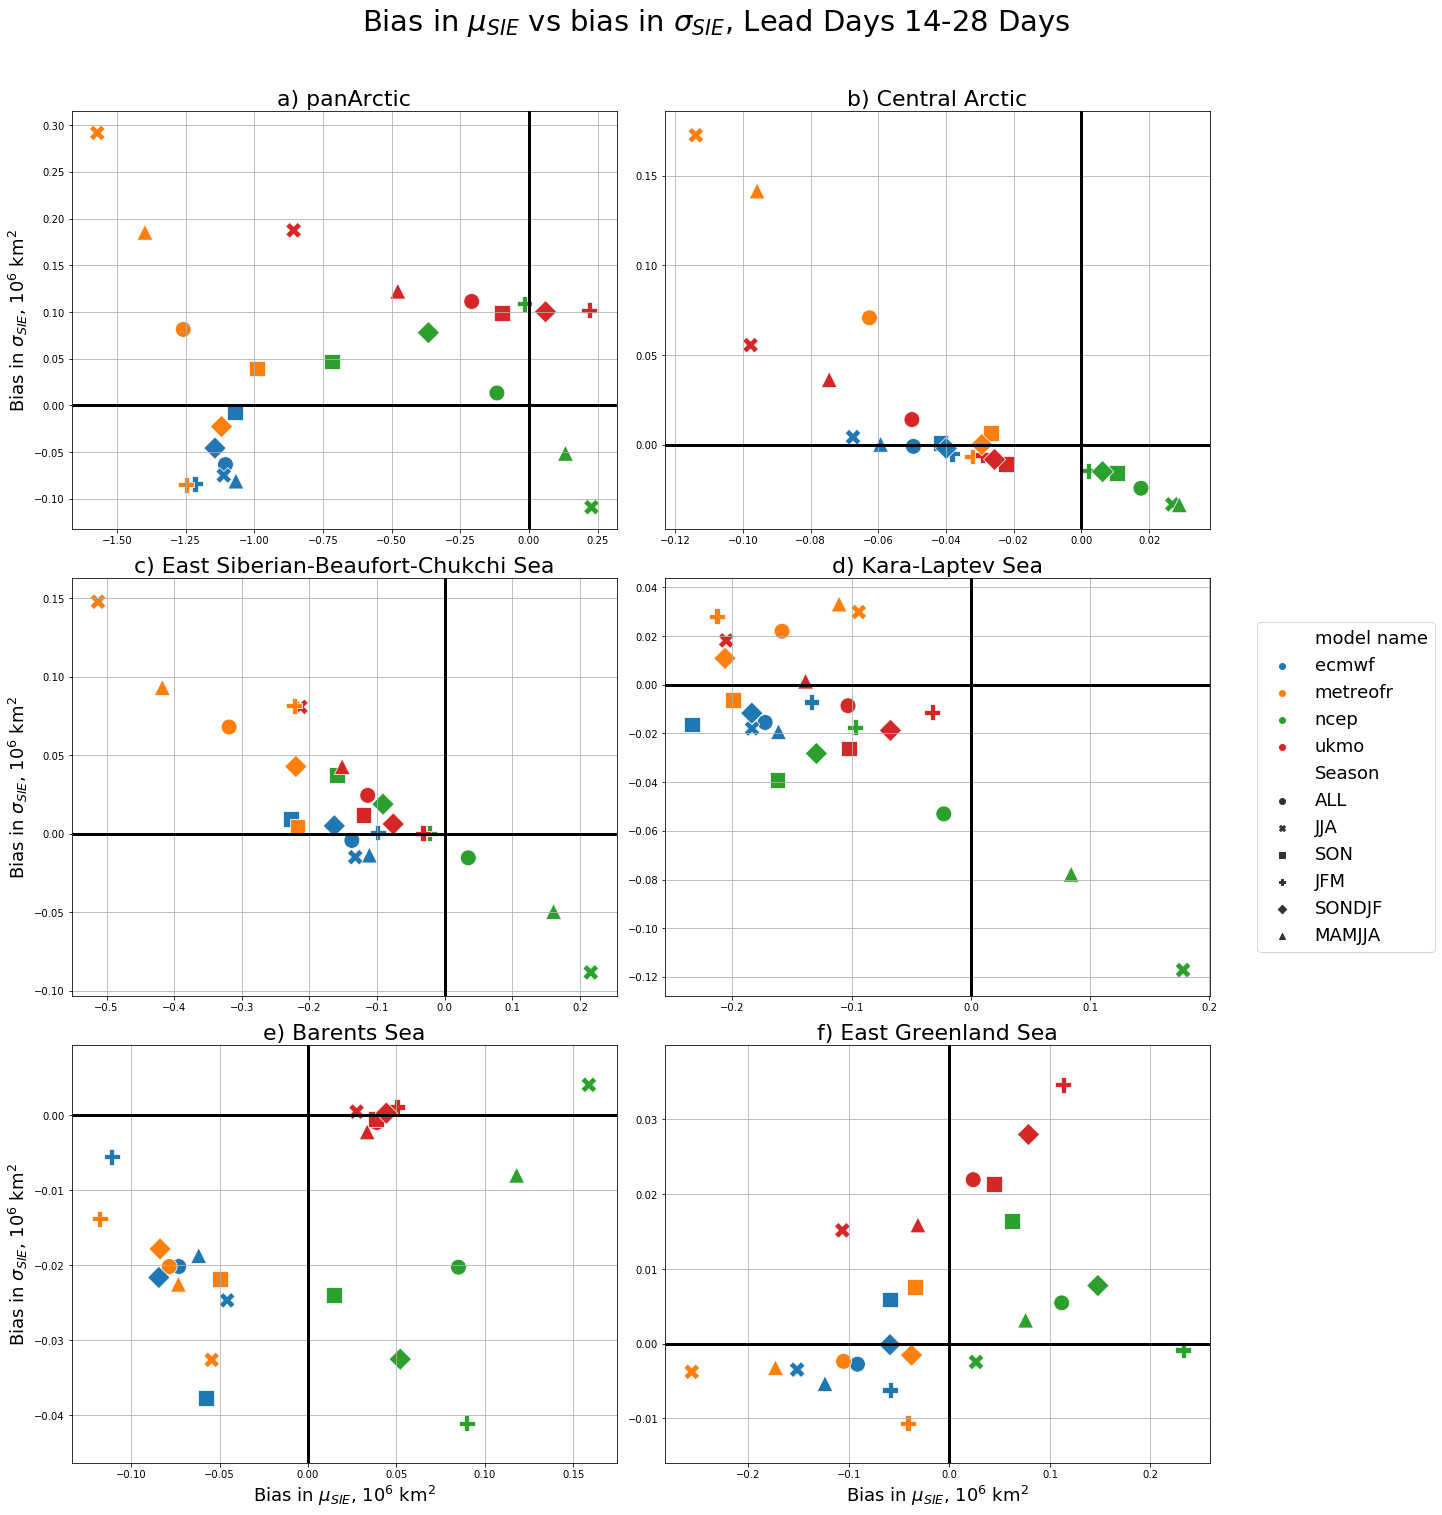

In [16]:
import seaborn as sns
#sns.set(style='whitegrid')
fig1,ax1 = plt.subplots(3,2,figsize=(20,20))
lett_all = ['a)','b)','c)','d)','e)','f)']
for iplt in np.arange(0,len(regions_sel)):
#iplt=0
    iregion_sel = regions_sel[iplt]
    ax_sel = ax1.flat[iplt]
    SIE_err_sel = SIE_seas_err_plt.xs(iregion_sel)#.reset_index()
    ax_sel.axhline(0,color='k',linewidth=3)
    ax_sel.axvline(0,color='k',linewidth=3)
    #
    #if (np.mod(iplt,2) == 0):
    
    spl = sns.scatterplot(data=SIE_err_sel.reset_index(),ax=ax_sel,x='SIE',y='SIE sd',hue='model name',style='Season',
               s=250,palette='tab10')
    ax_sel.grid()
    if iplt == 3:
        spl.legend(loc='center',bbox_to_anchor=(1.25,0.5),ncol=1,fontsize=18)
    else:
        spl.legend_.remove()
    #ax1.set_xlim([-0.35,0.15])
    group_avs = SIE_err_sel.mean(level=0)
    #sns.scatterplot(data=group_avs.reset_index(),x='SIE',y='SIE sd',style='model name',
    #            s=200,color='r',ax=ax_sel,legend=None,alpha=0.75)
    ax_sel.set_title('{i_lett} {ireg}'.format(i_lett=lett_all[iplt],ireg=iregion_sel),fontsize=22)
    if (np.mod(iplt,2)==0):
        ax_sel.set_ylabel('Bias in $\sigma_{SIE}$, 10$^6$ km$^2$',fontsize=18)
    else:
        ax_sel.set_ylabel(None)
    if (iplt > len(regions_sel)-3):
        ax_sel.set_xlabel('Bias in $\mu_{SIE}$, 10$^6$ km$^2$',fontsize=18)
    else:
        ax_sel.set_xlabel(None)

fig1.suptitle('Bias in $\mu_{{SIE}}$ vs bias in $\sigma_{{SIE}}$, Lead Days {min_lead}-{max_lead} Days'.format(min_lead=min_lead,max_lead=max_lead),y=1.05,fontsize=29)
fig1.tight_layout()
fig1_savename = '../FIGURES/Bias_mean_vs_bias_STD_compare_models_lead_days_{min_lead}-{max_lead}_days.pdf'.format(min_lead=min_lead,max_lead=max_lead)
fig1.savefig(fig1_savename,format='pdf',bbox_inches='tight')

Same Figure, but reorganized to emphasize seasons

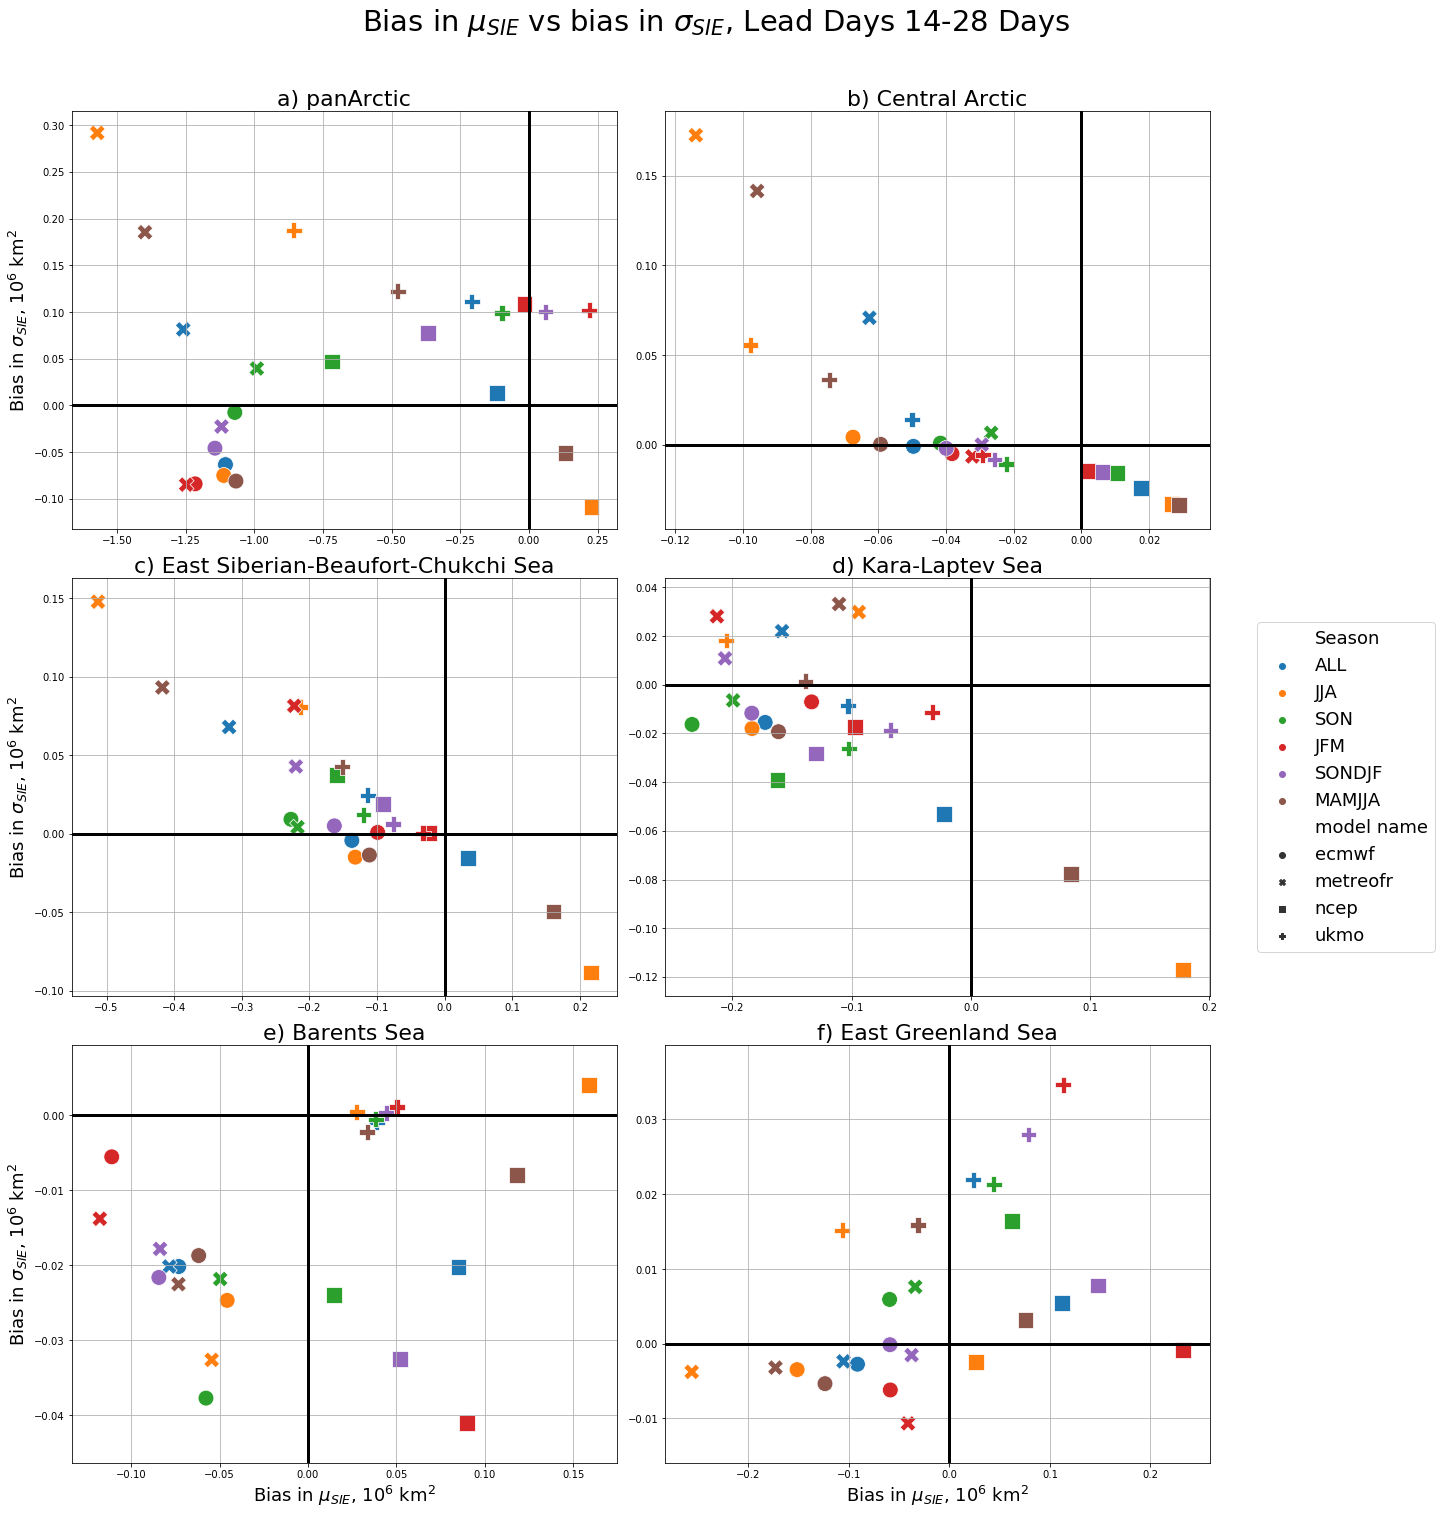

In [17]:
fig2,ax2 = plt.subplots(3,2,figsize=(20,20))
lett_all = ['a)','b)','c)','d)','e)','f)']
for iplt in np.arange(0,len(regions_sel)):
#iplt=0
    iregion_sel = regions_sel[iplt]
    ax_sel = ax2.flat[iplt]
    SIE_err_sel = SIE_seas_err_plt.xs(iregion_sel)#.reset_index()
    ax_sel.axhline(0,color='k',linewidth=3)
    ax_sel.axvline(0,color='k',linewidth=3)
    #
    #if (np.mod(iplt,2) == 0):
    
    spl = sns.scatterplot(data=SIE_err_sel.reset_index(),ax=ax_sel,x='SIE',y='SIE sd',hue='Season',style='model name',
               s=250,palette='tab10')
    ax_sel.grid()
    if iplt == 3:
        spl.legend(loc='center',bbox_to_anchor=(1.25,0.5),ncol=1,fontsize=18)
    else:
        spl.legend_.remove()
    #ax1.set_xlim([-0.35,0.15])
    group_avs = SIE_err_sel.mean(level=0)
    #sns.scatterplot(data=group_avs.reset_index(),x='SIE',y='SIE sd',style='model name',
    #            s=200,color='r',ax=ax_sel,legend=None,alpha=0.75)
    ax_sel.set_title('{i_lett} {ireg}'.format(i_lett=lett_all[iplt],ireg=iregion_sel),fontsize=22)
    if (np.mod(iplt,2)==0):
        ax_sel.set_ylabel('Bias in $\sigma_{SIE}$, 10$^6$ km$^2$',fontsize=18)
    else:
        ax_sel.set_ylabel(None)
    if (iplt > len(regions_sel)-3):
        ax_sel.set_xlabel('Bias in $\mu_{SIE}$, 10$^6$ km$^2$',fontsize=18)
    else:
        ax_sel.set_xlabel(None)

fig2.suptitle('Bias in $\mu_{{SIE}}$ vs bias in $\sigma_{{SIE}}$, Lead Days {min_lead}-{max_lead} Days'.format(min_lead=min_lead,max_lead=max_lead),y=1.05,fontsize=29)
fig2.tight_layout()
fig2_savename = '../FIGURES/Bias_mean_vs_bias_STD_compare_seas_lead_days_{min_lead}-{max_lead}_days.pdf'.format(min_lead=min_lead,max_lead=max_lead)
fig2.savefig(fig2_savename,format='pdf',bbox_inches='tight')